In [4]:
# Cell 1: Installations and Imports
# Make sure you have these libraries installed.
# You can install them using pip:
# pip install numpy scikit-learn trimesh torch torch_geometric Pillow matplotlib scipy %pip install pyfqmr 
# %pip install fast-simplification %pip install shapely

import numpy as np
import trimesh
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff
import math

# Helper function for PSNR calculation
def calculate_psnr(img1, img2):
    """Calculates the Peak Signal-to-Noise Ratio between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

print("Cell 1/11: All necessary libraries have been imported.")


Cell 1/11: All necessary libraries have been imported.


Successfully loaded 3D model.
Successfully loaded grayscale watermark.
Successfully loaded color watermark.

Model Vertices: 434864
Grayscale Watermark Bits: 16384
Color Watermark Bits (R,G,B flattened): 49152


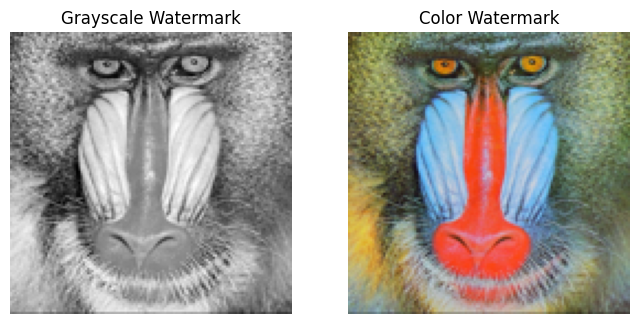

In [5]:
# Cell 2: Load Grayscale and Color Watermarks

# --- Image Settings ---
# You can adjust the size images are resized to.
IMAGE_DIMENSION = (128, 128)
# ----------------------

# Load the 3D model
try:
    mesh = trimesh.load_mesh('dragon.obj', force='mesh')
    print("Successfully loaded 3D model.")
except Exception as e:
    print(f"Error loading model. Creating a sample sphere as a placeholder.")
    mesh = trimesh.creation.icosphere(subdivisions=4)

mesh.vertices = mesh.vertices.astype(np.float64)
vertices = mesh.vertices

# --- Load Grayscale Watermark ---
try:
    grayscale_img = Image.open('watermark.png').convert('L')
    print(f"Successfully loaded grayscale watermark.")
except FileNotFoundError:
    print("'watermark.png' not found. Creating a placeholder image.")
    grayscale_img = Image.new('L', (64, 64))

grayscale_img = grayscale_img.resize(IMAGE_DIMENSION)
grayscale_data = np.array(grayscale_img).flatten()

# --- Load Color Watermark ---
try:
    color_img = Image.open('color_watermark.png').convert('RGB')
    print(f"Successfully loaded color watermark.")
except FileNotFoundError:
    print("'color_watermark.png' not found. Creating a placeholder image.")
    color_img = Image.new('RGB', (64, 64), 'blue')

color_img = color_img.resize(IMAGE_DIMENSION)
# Flatten the R, G, B channels into a single long array
color_data = np.array(color_img).flatten() 

# --- Normalize Data ---
# We use one scaler for all data to ensure consistent normalization
scaler = MinMaxScaler()
# Fit the scaler on a combined dataset to establish the full range
combined_data = np.concatenate((grayscale_data, color_data)).reshape(-1, 1)
scaler.fit(combined_data)

grayscale_data_normalized = scaler.transform(grayscale_data.reshape(-1, 1)).flatten()
color_data_normalized = scaler.transform(color_data.reshape(-1, 1)).flatten()

print(f"\nModel Vertices: {len(vertices)}")
print(f"Grayscale Watermark Bits: {len(grayscale_data_normalized)}")
print(f"Color Watermark Bits (R,G,B flattened): {len(color_data_normalized)}")

# Visualize the watermarks
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(grayscale_img, cmap='gray')
ax[0].set_title("Grayscale Watermark")
ax[0].axis('off')
ax[1].imshow(color_img)
ax[1].set_title("Color Watermark")
ax[1].axis('off')
plt.show()


In [6]:
# Cell 3: Raw GMM Clustering and Silhouette Score Analysis

print("Performing raw GMM clustering on model vertices...")

# Define a range of cluster numbers to test
n_clusters_range = range(2, 11)
silhouette_scores_gmm = []
best_score_gmm = -1
best_n_gmm = 0

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    labels = gmm.fit_predict(vertices)
    
    # Silhouette score requires at least 2 labels
    if len(set(labels)) > 1:
        score = silhouette_score(vertices, labels)
        silhouette_scores_gmm.append(score)
        print(f" - Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
        if score > best_score_gmm:
            best_score_gmm = score
            best_n_gmm = n_clusters
    else:
        silhouette_scores_gmm.append(-1) # Invalid score
        print(f" - Clusters: {n_clusters}, Not enough labels to calculate score.")


print(f"\nBest number of clusters for raw GMM is {best_n_gmm} with a silhouette score of {best_score_gmm:.4f}")

# Visualize the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores_gmm, marker='o', linestyle='--')
plt.title('Silhouette Score for Raw GMM Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.grid(True)
plt.show()


Performing raw GMM clustering on model vertices...


KeyboardInterrupt: 

In [ ]:
# Cell 4: GraphSAGE Feature Generation

print("Generating vertex embeddings using GraphSAGE...")

# Create a PyTorch Geometric Data object
edge_index = torch.tensor(mesh.edges.T, dtype=torch.long)
x = torch.tensor(vertices, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# Define a simple GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, 16)
        self.conv2 = SAGEConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate and run the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(in_channels=3, out_channels=16).to(device)
data = data.to(device)

with torch.no_grad():
    vertex_embeddings = model(data).cpu().numpy()

print("Generated vertex embeddings of shape:", vertex_embeddings.shape)


In [ ]:
# Cell 5: GMM + GraphSAGE Clustering and Silhouette Score Analysis

print("Performing GMM clustering on GraphSAGE embeddings...")

# --- FIX ---
# Ensure the embeddings are in float64 for better numerical stability.
vertex_embeddings_64 = vertex_embeddings.astype(np.float64)
# -----------

# Use the same range for a fair comparison
n_clusters_range = range(2, 11)
silhouette_scores_graphsage = []
best_score_graphsage = -1
best_n_graphsage = 0

for n_clusters in n_clusters_range:
    # --- FIX ---
    # Added reg_covar=1e-6 to regularize the covariance matrix.
    # This prevents errors from clusters with identical or co-linear points.
    gmm_graphsage = GaussianMixture(n_components=n_clusters, random_state=42, reg_covar=1e-6)
    # -----------
    
    labels = gmm_graphsage.fit_predict(vertex_embeddings_64)
    
    if len(set(labels)) > 1:
        score = silhouette_score(vertex_embeddings_64, labels)
        silhouette_scores_graphsage.append(score)
        print(f" - Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
        if score > best_score_graphsage:
            best_score_graphsage = score
            best_n_graphsage = n_clusters
    else:
        silhouette_scores_graphsage.append(-1)
        print(f" - Clusters: {n_clusters}, Not enough labels to calculate score.")

print(f"\nBest number of clusters for GMM+GraphSAGE is {best_n_graphsage} with a silhouette score of {best_score_graphsage:.4f}")

# Visualize the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores_graphsage, marker='o', linestyle='--', color='green')
plt.title('Silhouette Score for GMM + GraphSAGE Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.grid(True)
plt.show()


In [ ]:
# Cell 6: Visualize GMM+GraphSAGE Clustering Results

print(f"Visualizing the best clustering result ({best_n_graphsage} clusters)...")

# --- FIX ---
# We must use the same parameters here as in the previous cell to avoid the error.
# Use the float64 version of the embeddings.
vertex_embeddings_64 = vertex_embeddings.astype(np.float64)
# Add reg_covar to the final GMM instance.
final_gmm = GaussianMixture(n_components=best_n_graphsage, random_state=42, reg_covar=1e-6)
# -----------

cluster_labels = final_gmm.fit_predict(vertex_embeddings_64)

# Create colors for each cluster
colors = plt.cm.viridis(np.linspace(0, 1, best_n_graphsage))
vertex_colors = colors[cluster_labels]

# Create a new mesh with vertex colors for visualization
colored_mesh = trimesh.Trimesh(vertices=vertices, faces=mesh.faces, vertex_colors=vertex_colors)

# Show the clustered mesh
print("Displaying the 3D model with colored clusters. You can rotate the model in the interactive window.")
colored_mesh.show()


In [ ]:
# Cell 7: Find Best Two Clusters for Embedding (for Raw GMM)

print("Calculating entropy to select the best two clusters...")

cluster_entropies = []
for i in range(best_n_gmm):
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_vertices = vertices[cluster_indices]
    
    if len(cluster_vertices) > 1:
        covariance_matrix = np.cov(cluster_vertices, rowvar=False)
        entropy = np.linalg.det(covariance_matrix)
        # Store entropy along with the cluster index and its size
        cluster_entropies.append((entropy, i, len(cluster_indices)))
    else:
        cluster_entropies.append((0, i, len(cluster_indices)))

# Sort clusters by entropy in descending order (highest first)
cluster_entropies.sort(key=lambda x: x[0], reverse=True)

print("Clusters sorted by entropy (entropy, index, size):")
for e, i, s in cluster_entropies:
    print(f" - Cluster {i}: Entropy={e:.4e}, Size={s}")

# --- Assign Clusters to Watermarks ---
# Find the first cluster large enough for the COLOR watermark
best_cluster_indices_color = None
best_cluster_info_color = None
for entropy, index, size in cluster_entropies:
    if size >= len(color_data_normalized):
        best_cluster_indices_color = np.where(cluster_labels == index)[0]
        best_cluster_info_color = (index, size)
        break

# Remove the selected cluster from the list so it can't be chosen again
if best_cluster_info_color:
    cluster_entropies = [c for c in cluster_entropies if c[1] != best_cluster_info_color[0]]

# Find the next best cluster large enough for the GRAYSCALE watermark
second_best_cluster_indices_grayscale = None
second_best_cluster_info_grayscale = None
if best_cluster_indices_color is not None:
    for entropy, index, size in cluster_entropies:
        if size >= len(grayscale_data_normalized):
            second_best_cluster_indices_grayscale = np.where(cluster_labels == index)[0]
            second_best_cluster_info_grayscale = (index, size)
            break

# --- Final Check and Report ---
if best_cluster_indices_color is None:
    print("\nERROR: No cluster is large enough for the color watermark!")
else:
    print(f"\n✅ Assigned COLOR watermark to Cluster {best_cluster_info_color[0]} (Size: {best_cluster_info_color[1]})")

if second_best_cluster_indices_grayscale is None:
    print("ERROR: No remaining cluster is large enough for the grayscale watermark!")
else:
    print(f"✅ Assigned GRAYSCALE watermark to Cluster {second_best_cluster_info_grayscale[0]} (Size: {second_best_cluster_info_grayscale[1]})")


In [ ]:
# Cell 8: Embed Both Watermarks

print("Embedding both watermarks into their assigned clusters...")

# Create a copy of the vertices to modify
watermarked_vertices = np.copy(vertices)
embedding_strength = 0.005 
vertex_normals = mesh.vertex_normals

# --- Embed COLOR Watermark ---
if best_cluster_indices_color is not None:
    # Use only the portion of the watermark and target indices that will be used
    target_indices_color = best_cluster_indices_color[:len(color_data_normalized)]
    
    for i, vertex_idx in enumerate(target_indices_color):
        displacement = vertex_normals[vertex_idx] * color_data_normalized[i] * embedding_strength
        watermarked_vertices[vertex_idx] += displacement
    print(f"Color watermark embedded successfully.")
else:
    print("Skipping color watermark embedding (no suitable cluster found).")
    target_indices_color = []


# --- Embed GRAYSCALE Watermark ---
if second_best_cluster_indices_grayscale is not None:
    target_indices_grayscale = second_best_cluster_indices_grayscale[:len(grayscale_data_normalized)]

    for i, vertex_idx in enumerate(target_indices_grayscale):
        displacement = vertex_normals[vertex_idx] * grayscale_data_normalized[i] * embedding_strength
        watermarked_vertices[vertex_idx] += displacement
    print(f"Grayscale watermark embedded successfully.")
else:
    print("Skipping grayscale watermark embedding (no suitable cluster found).")
    target_indices_grayscale = []

# Create the final watermarked mesh
watermarked_mesh = trimesh.Trimesh(vertices=watermarked_vertices, faces=mesh.faces)

print("\nEmbedding complete.")
# Don't forget to run Cell 8.5 to save and reload this model for realistic testing.


In [ ]:
# Cell 8.5: Save and Reload Watermarked Model (for realistic evaluation)

print("Simulating a real-world scenario by saving and reloading the model...")

# Define a filename for the watermarked model
output_filename = 'watermarked_model.obj'

# Export the watermarked mesh to an OBJ file
watermarked_mesh.export(output_filename)

# --- CRUCIAL STEP ---
# Load the model back from the file. This introduces tiny precision errors,
# just like what would happen if you sent the file to someone else.
reloaded_watermarked_mesh = trimesh.load_mesh(output_filename)

# Update the watermarked_vertices variable to use the reloaded data
watermarked_vertices = reloaded_watermarked_mesh.vertices.astype(np.float64)


print(f"Model saved to '{output_filename}' and reloaded successfully.")
print("The extraction will now be performed on this reloaded, more realistic data.")


In [ ]:
# Cell 9: Extract Both Watermarks (Initial)

print("--- Extracting Both Watermarks from the Initial Model ---")

# Use the non-attacked, reloaded mesh from Cell 8.5
mesh_to_extract_from = reloaded_watermarked_mesh

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = mesh_to_extract_from.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = mesh_to_extract_from.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
# Color
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

# Grayscale
extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color")
ax[1].axis('off')
plt.show()

print("\nInitial extraction finished. Run Cell 10 to evaluate.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Rotation Attack 45%

# --- Parameters for this attack ---
rotation_angle_degrees = 45
output_filename = f'rotated_{rotation_angle_degrees}_model.obj'
# You can rotate around 'x', 'y', or 'z' axis
rotation_axis = 'z'
# ------------------------------------

print(f"Applying {rotation_angle_degrees}-degree rotation attack...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Convert degrees to radians for the transformation matrix
angle_radians = np.deg2rad(rotation_angle_degrees)

# Define the axis of rotation
if rotation_axis == 'x':
    direction = [1, 0, 0]
elif rotation_axis == 'y':
    direction = [0, 1, 0]
else: # Default to 'z' axis
    direction = [0, 0, 1]

# Create the rotation matrix
# The point of rotation is the object's center of mass
rotation_matrix = trimesh.transformations.rotation_matrix(
    angle=angle_radians,
    direction=direction,
    point=attacked_mesh.center_mass
)

# Apply the rotation to the mesh
attacked_mesh.apply_transform(rotation_matrix)

# Save the attacked model to its own file
attacked_mesh.export(output_filename)
print(f"Attacked model saved to '{output_filename}'.")


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'rotated_45_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11.5: Rotation Attack 90%

# --- Parameters for this attack ---
rotation_angle_degrees = 90
output_filename = f'rotated_{rotation_angle_degrees}_model.obj'
# You can rotate around 'x', 'y', or 'z' axis
rotation_axis = 'z'
# ------------------------------------

print(f"Applying {rotation_angle_degrees}-degree rotation attack...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Convert degrees to radians for the transformation matrix
angle_radians = np.deg2rad(rotation_angle_degrees)

# Define the axis of rotation
if rotation_axis == 'x':
    direction = [1, 0, 0]
elif rotation_axis == 'y':
    direction = [0, 1, 0]
else: # Default to 'z' axis
    direction = [0, 0, 1]

# Create the rotation matrix
# The point of rotation is the object's center of mass
rotation_matrix = trimesh.transformations.rotation_matrix(
    angle=angle_radians,
    direction=direction,
    point=attacked_mesh.center_mass
)

# Apply the rotation to the mesh
attacked_mesh.apply_transform(rotation_matrix)

# Save the attacked model to its own file
attacked_mesh.export(output_filename)
print(f"Attacked model saved to '{output_filename}'.")


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'rotated_90_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Remeshing Attack

# --- Parameters for this attack ---
# Percentage of faces to remove (e.g., 5 for 5%, 10 for 10%)
percentage_reduction = 5 
output_filename = f'remeshed_{percentage_reduction}percent_model.obj'
# ------------------------------------

# NOTE: This attack requires the 'fast-simplification' library.
# If you get an error, you may need to install it by running:
# pip install fast-simplification

print(f"Applying remeshing attack with {percentage_reduction}% face reduction...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Get the original number of faces
original_face_count = len(attacked_mesh.faces)
print(f"Original face count: {original_face_count}")

# Calculate the target number of faces after reduction
target_face_count = int(original_face_count * (1 - percentage_reduction / 100.0))
print(f"Target face count: {target_face_count}")

try:
    # Use the quadric decimation function which relies on 'fast-simplification'.
    attacked_mesh = attacked_mesh.simplify_quadric_decimation(face_count=target_face_count)
    
    print(f"New face count: {len(attacked_mesh.faces)}")

    # Save the attacked model to its own file
    attacked_mesh.export(output_filename)
    print(f"Attacked model saved to '{output_filename}'.")

except ModuleNotFoundError as e:
    if 'fast_simplification' in str(e):
        print("\n--- ERROR ---")
        print("The method 'simplify_quadric_decimation' failed because it requires the 'fast-simplification' library.")
        print("Please install it from your terminal or a new notebook cell:")
        print("!pip install fast-simplification")
        print("After installation, you MUST restart the Jupyter kernel for it to work.")
        print("-------------")
    else:
        # Re-raise the error if it's an unexpected ModuleNotFoundError
        raise e



In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'remeshed_5percent_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Remeshing Attack for 10%

# --- Parameters for this attack ---
# Percentage of faces to remove (e.g., 5 for 5%, 10 for 10%)
percentage_reduction = 10
output_filename = f'remeshed_{percentage_reduction}percent_model.obj'
# ------------------------------------

# NOTE: This attack requires the 'fast-simplification' library.
# If you get an error, you may need to install it by running:
# pip install fast-simplification

print(f"Applying remeshing attack with {percentage_reduction}% face reduction...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Get the original number of faces
original_face_count = len(attacked_mesh.faces)
print(f"Original face count: {original_face_count}")

# Calculate the target number of faces after reduction
target_face_count = int(original_face_count * (1 - percentage_reduction / 100.0))
print(f"Target face count: {target_face_count}")

try:
    # Use the quadric decimation function which relies on 'fast-simplification'.
    attacked_mesh = attacked_mesh.simplify_quadric_decimation(face_count=target_face_count)
    
    print(f"New face count: {len(attacked_mesh.faces)}")

    # Save the attacked model to its own file
    attacked_mesh.export(output_filename)
    print(f"Attacked model saved to '{output_filename}'.")

except ModuleNotFoundError as e:
    if 'fast_simplification' in str(e):
        print("\n--- ERROR ---")
        print("The method 'simplify_quadric_decimation' failed because it requires the 'fast-simplification' library.")
        print("Please install it from your terminal or a new notebook cell:")
        print("!pip install fast-simplification")
        print("After installation, you MUST restart the Jupyter kernel for it to work.")
        print("-------------")
    else:
        # Re-raise the error if it's an unexpected ModuleNotFoundError
        raise e



In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'remeshed_10percent_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Scaling Attack for 0.5

# --- Parameters for this attack ---
# Scaling factor (0.5 for 50%, 5 for 500%)
scaling_factor = 0.5 
output_filename = f'scaled_{scaling_factor}_model.obj'
# ------------------------------------

print(f"Applying scaling attack with a factor of {scaling_factor}...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Create the scaling transformation matrix
# The transformation is applied relative to the object's center of mass
scaling_matrix = trimesh.transformations.scale_matrix(
    factor=scaling_factor,
    origin=attacked_mesh.center_mass
)

# Apply the scaling to the mesh
attacked_mesh.apply_transform(scaling_matrix)

# Save the attacked model to its own file
attacked_mesh.export(output_filename)
print(f"Attacked model saved to '{output_filename}'.")


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'scaled_0.5_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Scaling Attack for 5

# --- Parameters for this attack ---
# Scaling factor (0.5 for 50%, 5 for 500%)
scaling_factor = 5
output_filename = f'scaled_{scaling_factor}_model.obj'
# ------------------------------------

print(f"Applying scaling attack with a factor of {scaling_factor}...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Create the scaling transformation matrix
# The transformation is applied relative to the object's center of mass
scaling_matrix = trimesh.transformations.scale_matrix(
    factor=scaling_factor,
    origin=attacked_mesh.center_mass
)

# Apply the scaling to the mesh
attacked_mesh.apply_transform(scaling_matrix)

# Save the attacked model to its own file
attacked_mesh.export(output_filename)
print(f"Attacked model saved to '{output_filename}'.")


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'scaled_5_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Random Noise Attack for 0.01

# --- Parameters for this attack ---
# Noise strength (lambda λ)
noise_strength = 0.01 
output_filename = f'noisy_{noise_strength}_model.obj'
# ------------------------------------

print(f"Applying random noise attack with strength (λ) of {noise_strength}...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Generate random noise with the same shape as the vertices array
# The noise is sampled from a standard normal distribution and then scaled by the strength
noise = np.random.randn(*attacked_mesh.vertices.shape) * noise_strength

# Add the noise to the vertex positions
attacked_mesh.vertices += noise

# Save the attacked model to its own file
attacked_mesh.export(output_filename)
print(f"Attacked model saved to '{output_filename}'.")


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'noisy_0.01_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Random Noise Attack for 0.15

# --- Parameters for this attack ---
# Noise strength (lambda λ)
noise_strength = 0.15
output_filename = f'noisy_{noise_strength}_model.obj'
# ------------------------------------

print(f"Applying random noise attack with strength (λ) of {noise_strength}...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Generate random noise with the same shape as the vertices array
# The noise is sampled from a standard normal distribution and then scaled by the strength
noise = np.random.randn(*attacked_mesh.vertices.shape) * noise_strength

# Add the noise to the vertex positions
attacked_mesh.vertices += noise

# Save the attacked model to its own file
attacked_mesh.export(output_filename)
print(f"Attacked model saved to '{output_filename}'.")


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'noisy_0.15_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Cropping Attack

# --- Parameters for this attack ---
# Percentage of the model to crop away from the top
crop_percentage = 10 
output_filename = f'cropped_{crop_percentage}percent_model.obj'
# The axis to crop along ('x', 'y', or 'z')
crop_axis = 'z'
# ------------------------------------

# NOTE: This attack requires the 'shapely' library for slicing operations.
# If you get an error, you may need to install it by running:
# pip install shapely

print(f"Applying cropping attack, removing {crop_percentage}% of the model...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Determine the axis index (0=x, 1=y, 2=z)
axis_map = {'x': 0, 'y': 1, 'z': 2}
axis_index = axis_map.get(crop_axis, 2)

# Get the bounding box of the model to determine its extent
min_bound, max_bound = attacked_mesh.bounds

# Calculate the point along the axis at which to crop
crop_point = max_bound[axis_index] - (max_bound[axis_index] - min_bound[axis_index]) * (crop_percentage / 100.0)

# Define the plane normal for slicing (points towards the part we want to remove)
plane_normal = [0, 0, 0]
plane_normal[axis_index] = 1.0

# Define the origin of the slicing plane
plane_origin = [0, 0, 0]
plane_origin[axis_index] = crop_point

try:
    # Use a boolean slice to keep only the part of the mesh below the plane
    # This effectively crops the top part of the model
    cropped_mesh = attacked_mesh.slice_plane(plane_origin=plane_origin, plane_normal=plane_normal)

    # Save the attacked model to its own file
    cropped_mesh.export(output_filename)
    print(f"Attacked model saved to '{output_filename}'.")

except ModuleNotFoundError as e:
    if 'shapely' in str(e):
        print("\n--- ERROR ---")
        print("The method 'slice_plane' failed because it requires the 'shapely' library.")
        print("Please install it from your terminal or a new notebook cell:")
        print("!pip install shapely")
        print("After installation, you MUST restart the Jupyter kernel for it to work.")
        print("-------------")
    else:
        # Re-raise the error if it's an unexpected ModuleNotFoundError
        raise e


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'cropped_10percent_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")


In [ ]:
# Cell 11: Cropping Attack

# --- Parameters for this attack ---
# Percentage of the model to crop away from the top
crop_percentage = 20
output_filename = f'cropped_{crop_percentage}percent_model.obj'
# The axis to crop along ('x', 'y', or 'z')
crop_axis = 'z'
# ------------------------------------

# NOTE: This attack requires the 'shapely' library for slicing operations.
# If you get an error, you may need to install it by running:
# pip install shapely

print(f"Applying cropping attack, removing {crop_percentage}% of the model...")

# Start with the reloaded watermarked mesh from Cell 8.5
attacked_mesh = reloaded_watermarked_mesh.copy()

# Determine the axis index (0=x, 1=y, 2=z)
axis_map = {'x': 0, 'y': 1, 'z': 2}
axis_index = axis_map.get(crop_axis, 2)

# Get the bounding box of the model to determine its extent
min_bound, max_bound = attacked_mesh.bounds

# Calculate the point along the axis at which to crop
crop_point = max_bound[axis_index] - (max_bound[axis_index] - min_bound[axis_index]) * (crop_percentage / 100.0)

# Define the plane normal for slicing (points towards the part we want to remove)
plane_normal = [0, 0, 0]
plane_normal[axis_index] = 1.0

# Define the origin of the slicing plane
plane_origin = [0, 0, 0]
plane_origin[axis_index] = crop_point

try:
    # Use a boolean slice to keep only the part of the mesh below the plane
    # This effectively crops the top part of the model
    cropped_mesh = attacked_mesh.slice_plane(plane_origin=plane_origin, plane_normal=plane_normal)

    # Save the attacked model to its own file
    cropped_mesh.export(output_filename)
    print(f"Attacked model saved to '{output_filename}'.")

except ModuleNotFoundError as e:
    if 'shapely' in str(e):
        print("\n--- ERROR ---")
        print("The method 'slice_plane' failed because it requires the 'shapely' library.")
        print("Please install it from your terminal or a new notebook cell:")
        print("!pip install shapely")
        print("After installation, you MUST restart the Jupyter kernel for it to work.")
        print("-------------")
    else:
        # Re-raise the error if it's an unexpected ModuleNotFoundError
        raise e


In [ ]:
# Cell 12: Extract Both Watermarks After Attack

# --- Specify which attacked model to load ---
# This MUST match the 'output_filename' from your attack cell (Cell 11)
filename_to_evaluate = 'cropped_20percent_model.obj'
# --------------------------------------------

print(f"--- Extracting Both Watermarks from Attacked Model: '{filename_to_evaluate}' ---")

# 1. Load the specified attacked model
try:
    loaded_attacked_mesh = trimesh.load_mesh(filename_to_evaluate)
    print(f"Successfully loaded '{filename_to_evaluate}'.")
    display(loaded_attacked_mesh.scene().show())
except Exception as e:
    print(f"ERROR: Could not load '{filename_to_evaluate}'. Please run the attack cell first.")
    # Stop execution if the file doesn't exist
    raise e

# --- Setup for Extraction ---
from scipy.spatial import KDTree
original_vertices = mesh.vertices
attacked_vertices = loaded_attacked_mesh.vertices.astype(np.float64)
attacked_tree = KDTree(attacked_vertices)
attacked_normals = loaded_attacked_mesh.vertex_normals

# --- Helper Function to Extract a Single Watermark ---
def extract_watermark(target_indices):
    extracted_data = []
    for i, vertex_idx in enumerate(target_indices):
        original_v = original_vertices[vertex_idx]
        distance, attacked_idx = attacked_tree.query(original_v)
        attacked_v = attacked_vertices[attacked_idx]
        normal_v = attacked_normals[attacked_idx]
        
        displacement_vector = attacked_v - original_v
        projected_displacement = np.dot(displacement_vector, normal_v)
        extracted_value = projected_displacement / embedding_strength
        extracted_data.append(extracted_value)
    
    normalized_data = np.array(extracted_data).reshape(-1, 1)
    pixel_data = scaler.inverse_transform(normalized_data)
    return pixel_data

# --- Extract Both Watermarks ---
extracted_pixels_color = extract_watermark(target_indices_color)
extracted_pixels_grayscale = extract_watermark(target_indices_grayscale)
print("Extraction complete.")

# --- Reshape and Visualize ---
extracted_color_array = extracted_pixels_color.flatten()
extracted_color_img_array = np.clip(extracted_color_array, 0, 255).astype('uint8').reshape((*IMAGE_DIMENSION, 3))

extracted_grayscale_array = extracted_pixels_grayscale.flatten()
extracted_grayscale_img_array = np.clip(extracted_grayscale_array, 0, 255).astype('uint8').reshape(IMAGE_DIMENSION)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(extracted_grayscale_img_array, cmap='gray')
ax[0].set_title("Extracted Grayscale (Attacked)")
ax[0].axis('off')
ax[1].imshow(extracted_color_img_array)
ax[1].set_title("Extracted Color (Attacked)")
ax[1].axis('off')
plt.show()

print("\nPost-attack extraction finished. Re-run Cell 10 to evaluate robustness.")


In [ ]:
# Cell 10: Evaluate Both Watermarks

print("--- Calculating Evaluation Metrics ---")

# --- Grayscale Watermark Evaluation ---
print("\n--- Grayscale Watermark ---")
original_gs_flat = grayscale_data[:len(extracted_pixels_grayscale)]
extracted_gs_flat = extracted_pixels_grayscale.flatten()

# 1. RMSE
rmse_gs = np.sqrt(np.mean((original_gs_flat - extracted_gs_flat) ** 2))
print(f" - RMSE: {rmse_gs:.4f}")

# 2. NCC
ncc_gs = np.corrcoef(original_gs_flat, extracted_gs_flat)[0, 1]
print(f" - NCC: {ncc_gs:.4f}")

# 3. PSNR
psnr_gs = calculate_psnr(np.array(grayscale_img), extracted_grayscale_img_array)
print(f" - PSNR: {psnr_gs:.4f} dB")


# --- Color Watermark Evaluation ---
print("\n--- Color Watermark ---")
original_color_flat = color_data[:len(extracted_pixels_color)]
extracted_color_flat = extracted_pixels_color.flatten()

# 1. RMSE
rmse_color = np.sqrt(np.mean((original_color_flat - extracted_color_flat) ** 2))
print(f" - RMSE: {rmse_color:.4f}")

# 2. NCC
ncc_color = np.corrcoef(original_color_flat, extracted_color_flat)[0, 1]
print(f" - NCC: {ncc_color:.4f}")

# 3. PSNR
psnr_color = calculate_psnr(np.array(color_img), extracted_color_img_array)
print(f" - PSNR: {psnr_color:.4f} dB")


# --- Overall Model Metrics ---
print("\n--- Overall Model Metrics ---")
# 4. Hausdorff Distance (compares original model to the final watermarked model)
# This assumes 'watermarked_vertices' is from the non-attacked, reloaded mesh
hausdorff_dist_1 = directed_hausdorff(original_vertices, watermarked_vertices)[0]
hausdorff_dist_2 = directed_hausdorff(watermarked_vertices, original_vertices)[0]
hausdorff_distance = max(hausdorff_dist_1, hausdorff_dist_2)
print(f" - Hausdorff Distance: {hausdorff_distance:.6f}")

# 5. Bit Embedding Rate (total bits embedded from both watermarks)
total_bits_embedded = (len(target_indices_color) + len(target_indices_grayscale)) * 8
bit_embedding_rate = total_bits_embedded / len(vertices)
print(f" - Bit Embedding Rate: {bit_embedding_rate:.4f} bits per vertex")
